# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`, (use "laptop.jpg" for testing)
2. Upload an text file as `SOURCE_POINTS_FILE`, (use "laptop_screen.txt" for testing)
3. Upload an text file as `TARGET_POINTS_FILE`, and (use "laptop_rect.txt" for testing)
4. Run `rectify()` and show the output image.


In [627]:
import numpy as np

def build_A(pts1, pts2):
    """Constructs the intermediate matrix A used in the computation of an
    homography mapping pts1 to pts2."""

    # Build and return A
    A = []
    for i in range(len(pts1)):
        xS = pts1[i][0]
        yS = pts1[i][1]
        
        xD = pts2[i][0]
        yD = pts2[i][1]
        
        upperRow = [xS, yS, 1, 0, 0, 0,  - xD * xS, - xD * yS, - xD]
        lowerRow = [0, 0, 0, xS, yS, 1,  - yD * xS, - yD * yS, - yD]
        A.append(upperRow)
        A.append(lowerRow)
    
    return np.array(A)
    


In [702]:
def compute_H(pts1, pts2):
    """Computes an homography mapping one set of co-planar points (pts1) to another (pts2)."""

    # Construct the intermediate A matrix.
    A = build_A(pts1, pts2)
    
    # Compute the symmetric matrix AtA.
    AtA = np.dot(A.T, A)

    # Compute the eigenvalues and eigenvectors of AtA.
    eigenvalues, eigenvectors = np.linalg.eigh(AtA)

    # Return the eigenvector corresponding to the smallest eigenvalue, reshaped
    # as a 3x3 matrix.
    smallestEVIndex = np.argmin(eigenvalues)
    h = eigenvectors[:, smallestEVIndex]
    H = h.reshape((3, 3))
    
    return H

In [711]:
def bilinear_interp(image, point):
    """Looks up the pixel values in an image at a given point using bilinear
    interpolation."""
    
    image = np.array(image)

    # Compute the four integer corner coordinates (top-left/right,
    # bottom-left/right) for interpolation, as well as the fractional part of
    # the coordinates.
    x, y = point
    x0 = int(x)
    y0 = int(y)
    x1 = min(x0 + 1, image.shape[1] - 1)  # within bounds
    y1 = min(y0 + 1, image.shape[0] - 1)
    
    # Calculate the fractional part of the coordinates
    a = x - x0
    b = y - y0

    # Interpolate between the top two pixels.
    interTop = (1 - a) * image[y0, x0] + a * image[y0, x1]
    
    # Interpolate between the bottom two pixels.
    interBottom = (1 - a) * image[y1, x0] + a * image[y1, x1]

    # Return the result of the final interpolation between top and bottom.
    interFinal = (1 - b) * interTop + b * interBottom
    
    return interFinal.astype(int)

In [719]:
def warp_homography(source, target_shape, Hinv):
    """Warp the source image into the target coordinate frame using a provided
    inverse homography transformation."""
    # NOTE: This can be done much more efficiently (>10x faster) in Python
    # using a series of numpy array operations as opposed to a for loop.

    # Hints for fast version:
    # * Read about numpy broadcasting rules and reshaping operations.
    # * Look up numpy.mgrid / meshgrid for tips on how to quickly generate an
    #   array containing coordinates of all of the points in an image.
    # * You can modify your bilinear_interp() function to take an array of
    #   points instead of single points. Express the actions in this function
    #   using the aforementioned array operations.

    # Warp the source image to the corresponding coordinate system in the
    # output image by:
    #     * transforming points in the output image to the source image space (using the homography)
    #     * looking up pixel values in the source image at the transformed points (using bilinear interpolation)

    # Return the output image.
    
    height, width, _ = source.shape
    targetHeight, targetWidth = target_shape

    outImage = np.zeros((targetHeight, targetWidth, 3), dtype=np.uint8)

    for y in range(targetHeight):
        for x in range(targetWidth):
            posInSource = Hinv.dot([x, y, 1])
            posInSource /= posInSource[2]
            
            xyInSource = posInSource[:2]
            if 0 <= xyInSource[0] < width and 0 <= xyInSource[1] < height:
                rgb = bilinear_interp(source, xyInSource)
            else:
                rgb = [0, 0, 0]

            outImage[y, x] = rgb

    return outImage

    

In [726]:
def rectify(image, planar_points, target_points):
    # Compute the rectifying homography that warps the planar points to the
    # target rectangular region.
    H = compute_H(planar_points, target_points)
    
    # Apply the rectifying homography to the bounding box of the planar image
    # to find its corresponding bounding box in the rectified space.
    height, width, xxx = image.shape
    
    topLeft = H.dot([0, 0, 1])
    topLeft /= topLeft[2]
    
    topRight = H.dot([width - 1, 0, 1])
    topRight /= topRight[2]
    
    lowLeft = H.dot([0, height - 1, 1])
    lowLeft /= lowLeft[2]
    
    lowRight = H.dot([width - 1, height - 1, 1])
    lowRight /= lowRight[2]

    # Offset the rectified bounding box such that its minimum point (the top
    # left corner) lies at the origin of the rectified space.
    min_x = np.array([topLeft[0], topRight[0], lowLeft[0], lowRight[0]]).min()
    min_y = np.array([topLeft[1], topRight[1], lowLeft[1], lowRight[1]]).min()
    max_x = np.array([topLeft[0], topRight[0], lowLeft[0], lowRight[0]]).max()
    max_y = np.array([topLeft[1], topRight[1], lowLeft[1], lowRight[1]]).max()
    
    offset = -np.array([min_x, min_y, 0])
    
    # Compute the inverse homography to warp between the offset, rectified
    # bounding box and the bounding box of the input image.
    HTransl = np.array([[1, 0, offset[0]],
                        [0, 1, offset[1]],
                        [0, 0, 1]])
    Hinv = np.linalg.inv(HTransl.dot(H))

    # Perform inverse warping and return the result.
    xTargetSize = int(max_x - min_x + 1)
    yTargetSize = int(max_y - min_y + 1)
    target_shape = (yTargetSize, xTargetSize)
    result = warp_homography(image, target_shape, Hinv)
    
    return result
    

In [800]:
# colaboratory-specific helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# def upload_sub(msg):
#     print(msg)
#     f = files.upload()
#     if bool(f) is False:
#         return None
#     fname = list(f.keys())[0]
#     return fname

# def upload(msg):
#     f = None
#     while f is None:
#         f = upload_sub(msg)
#     return f


## Step 1-1: Upload `IMAGE`

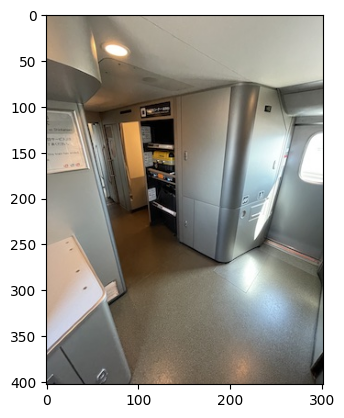

In [805]:
image = cv2.imread("myTest/shinkansen.jpeg", cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [806]:
pts1 = np.loadtxt("myTest/wall.txt") # Use laptop_screen.txt for testing
print(pts1)

[[147.  88.]
 [202.  79.]
 [190. 210.]
 [149. 197.]]


## Step 1-3:  TARGET_POINTS_FILE

In [807]:
pts2 = np.loadtxt("myTest/wall_target.txt") # Use laptop_rect.txt for testing
print(pts2)

[[  0.   0.]
 [100.   0.]
 [100. 200.]
 [  0. 200.]]


## Step 1-4: Rectify

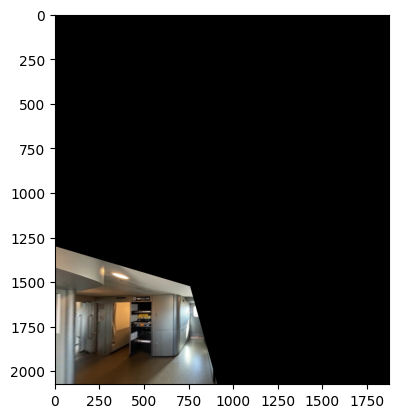

In [808]:
rectified = rectify(image, pts1, pts2).astype(np.uint8)

plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))

# Just in case you want to download the output

# cv2.imwrite("rectified.png", rectified)
# files.download('rectified.png')

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [811]:
def blend_with_mask(source, target, mask):
    """Blends the source image with the target image according to the mask.
    Pixels with value "1" are source pixels, "0" are target pixels, and
    intermediate values are interpolated linearly between the two."""
    
    height, width, _ = target.shape

    outImage = np.zeros((height, width, 3), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            # alpha = mask[x,y]
            # out = alpha * source[x,y] + (1 - alpha) * target[x,y]
            # outImage[x,y] = out
            if np.array_equal(source[y, x], [0, 0, 0]):
                outImage[y,x] = target[y,x]
            else:
                outImage[y,x] = source[y,x]
                

    return outImage

In [812]:
def composite(source, target, source_pts, target_pts, mask):
    """Composites a masked planar region of the source image onto a
    corresponding planar region of the target image via homography warping."""

    # Compute the homography to warp points from the target to the source coordinate frame.
    H = compute_H(source_pts, target_pts)

    # Warp the images using the homography.
    target_shape = [target.shape[0], target.shape[1]]
    Hinv = np.linalg.inv(H)
    
    warpedSource = warp_homography(source, target_shape, Hinv)

    # Blend the warped images.
    result = blend_with_mask(warpedSource, target, mask)
    
    
    return result

## Step 2-1: Upload `SOURCE` image

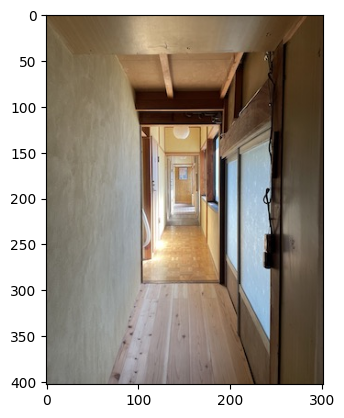

In [813]:
source = cv2.imread("myTest/corridor.jpeg", cv2.IMREAD_COLOR) # Use panda.png for testing
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

## Step 2-2: Upload `TARGET` image

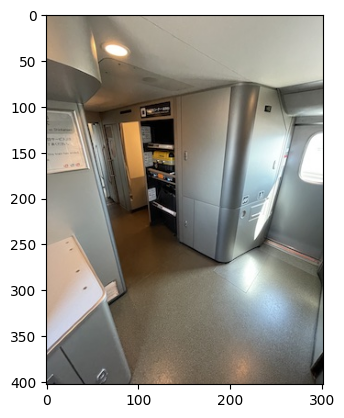

In [814]:
target = cv2.imread("myTest/shinkansen.jpeg", cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [815]:
source_pts = np.loadtxt("myTest/corridor_points.txt") # Use panda_point.txt for testing
print(source_pts)

[[  0.   0.]
 [302.   0.]
 [302. 403.]
 [  0. 403.]]


## Step 2-4: Upload `TARGET_POINTS` file

In [819]:
target_pts = np.loadtxt("myTest/wall.txt") # Use laptop_screen.txt for testing
print(target_pts)

[[147.  88.]
 [202.  79.]
 [190. 210.]
 [149. 197.]]


## Step 2-5: Upload `MASK` image

(336, 449)
(336, 449, 1)


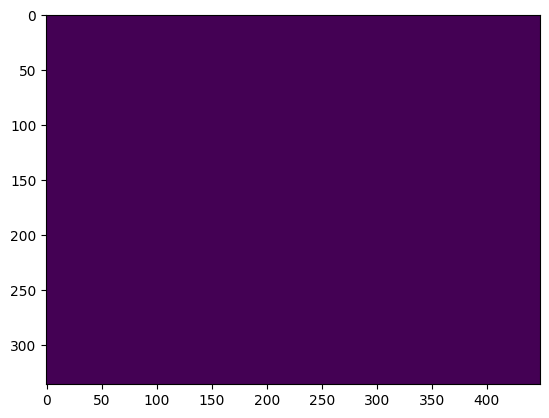

In [820]:
mask = cv2.imread('test_data/panda_mask.png', cv2.IMREAD_GRAYSCALE) # Use panda_mask.png for testing
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]
print(mask.shape)

## Step 2-6: Composite

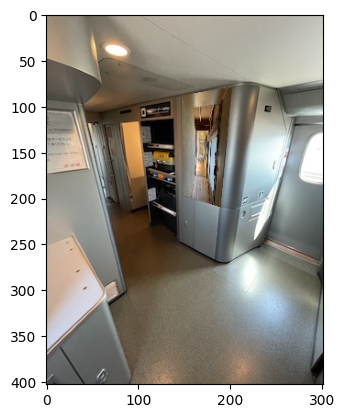

In [821]:
composited = composite(source, target, source_pts, target_pts, mask/255.0).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))